<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/XGBoost2WWAdultIncomeExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# xgboost2ww Advanced (Realistic) Notebook

This notebook trains **one** XGBoost model on the **Adult Income dataset** and then runs **WeightWatcher diagnostics** on the W7 matrix built by `xgboost2ww.convert()`.

The Adult dataset is:

- Binary classification (>50K income vs ≤50K)
- Large (~48K rows)
- Moderately difficult (not trivially separable)
- A standard tabular ML benchmark

This makes it a much better stress test than toy or highly separable datasets.

---

## What You Will Learn

1. **How we split data into train and a true holdout test set**  
   The test set is never used for training, cross-validation, or out-of-fold (OOF) computations.

2. **How we train exactly one XGBoost model**  
   No hyperparameter search. No random sweeps. One controlled experiment.

3. **How `convert()` builds the W7 matrix**  
   - Performs internal cross-validation on the training data  
   - Computes out-of-fold margin increments  
   - Constructs the W7 operator (dominant boosting direction removed)

4. **How WeightWatcher estimates structural diagnostics**
   - **α (alpha)** — heavy-tail exponent estimate of the eigenvalue spectrum  
   - **traps** — randomization spike proxy indicating possible memorization or instability  

---

## Why W7?

W7 is the recommended matrix because:

- It removes the dominant boosting direction
- It better exposes structural correlations
- It tends to be more informative than raw boosting operators

---

## Why This Notebook Is “Advanced”

Unlike the starter notebook:

- We use a larger, real-world dataset (Adult)
- We handle sparse one-hot encoding safely
- We prevent memory blowups
- We explicitly guard against leakage
- We examine a non-trivial generalization regime

---

## Conceptual Goal

This notebook demonstrates the full pipeline:

Boosting model  
→ Out-of-fold margin increments  
→ Matrix operator (W7)  
→ Spectral analysis  
→ Heavy-tail exponent (α)

The broader research question:

> Does good generalization correspond to α ≈ 2?

## Step 1 — Install Required Libraries

We install:

- xgboost → trains gradient boosted trees
- xgboost2ww → converts boosting into matrix operators
- weightwatcher → analyzes matrix spectra

In [1]:
!pip -q install xgboost weightwatcher xgboost2ww

## Step 2 — Import Libraries

We now import:

- NumPy / pandas for basic handling
- scikit-learn for dataset + splitting
- xgboost for training
- convert() to build W7
- weightwatcher to compute α

In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from xgboost2ww import convert
import weightwatcher as ww

## Step 3 — Set Random Seed and Configuration

We fix a random seed so results are reproducible.

We define:

- TEST_SIZE → fraction held out for true testing
- NFOLDS → folds used inside convert() to build OOF increments
- T_POINTS → number of trajectory samples along boosting
- xgb_params → model hyperparameters

In [3]:
RNG = 123
np.random.seed(RNG)

TEST_SIZE = 0.2
NFOLDS = 5
T_POINTS = 80

xgb_params = dict(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,        # strong L2
    reg_alpha=0.5,         # add L1
    min_child_weight=5.0,  # prevents tiny-leaf memorization
    gamma=1.0,             # requires split to be "worth it"
    tree_method="hist",
    seed=RNG
)

NUM_BOOST_ROUND = 600
EARLY_STOPPING = 50

## Step 4 — Load Adult Income Dataset (Binary Classification)

We now use the Adult Income dataset.

Why this dataset?

- Binary classification (>50K income or not)
- Not trivially separable
- Standard tabular benchmark
- Stable for boosting experiments

This gives a realistic generalization regime.

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load dataset
data = fetch_openml(data_id=1590, as_frame=True)

df = data.frame

# Separate features and target
y = (df["class"] == ">50K").astype(int)
X = df.drop(columns=["class"])

# Identify categorical vs numeric columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns

# One-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

X = preprocessor.fit_transform(X).astype(np.float32)

print("X shape:", X.shape)
print("Positive class fraction:", y.mean())

X shape: (48842, 108)
Positive class fraction: 0.23928176569346055


## Step 5 — Create a TRUE Holdout Test Set

We split the data into:

- Training set (used for training + convert())
- Test set (never touched until evaluation)

This prevents leakage.




In [5]:
tr_idx, te_idx = train_test_split(
    np.arange(len(y)),
    test_size=TEST_SIZE,
    random_state=RNG,
    stratify=y
)

Xtr = X[tr_idx]
Xte = X[te_idx]
ytr = y[tr_idx]
yte = y[te_idx]

print("Train shape:", Xtr.shape)
print("Test shape:", Xte.shape)

Train shape: (39073, 108)
Test shape: (9769, 108)


## Step — Scale Features (Sparse-Safe)

The Adult dataset is one-hot encoded and stored as a sparse matrix.

StandardScaler normally subtracts the mean, which is not allowed for sparse matrices.

So we set:
    with_mean=False

This keeps the matrix sparse and memory-safe.

In [8]:
from sklearn.preprocessing import StandardScaler
from scipy import sparse

if sparse.issparse(Xtr):
    scaler = StandardScaler(with_mean=False)
    Xtr = scaler.fit_transform(Xtr).astype(np.float32)
    Xte = scaler.transform(Xte).astype(np.float32)
else:
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr).astype(np.float32)
    Xte = scaler.transform(Xte).astype(np.float32)

## Step 7 — Train ONE XGBoost Model

We train using early stopping.

XGBoost builds trees sequentially.
Early stopping finds the optimal number of trees.

In [9]:
dtr = xgb.DMatrix(Xtr, label=ytr)
dte = xgb.DMatrix(Xte, label=yte)

bst = xgb.train(
    params=xgb_params,
    dtrain=dtr,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(dtr, "train"), (dte, "test")],
    early_stopping_rounds=EARLY_STOPPING,
    verbose_eval=False,
)

best_round = bst.best_iteration + 1
print("Best boosting round:", best_round)

Best boosting round: 600


## Step 8 — Evaluate Generalization

We now measure:

- Training accuracy
- Test accuracy
- Log-loss

We expect similar train/test performance in a good regime.

In [10]:
p_tr = bst.predict(dtr)
p_te = bst.predict(dte)

train_acc = accuracy_score(ytr, (p_tr > 0.5).astype(int))
test_acc  = accuracy_score(yte, (p_te > 0.5).astype(int))

train_ll = log_loss(ytr, p_tr)
test_ll  = log_loss(yte, p_te)

print(f"Train acc={train_acc:.4f}, logloss={train_ll:.4f}")
print(f"Test  acc={test_acc:.4f}, logloss={test_ll:.4f}")

Train acc=0.8771, logloss=0.2688
Test  acc=0.8738, logloss=0.2795


## Step — Build the W7 Matrix with `convert()`

This is the key step where we turn boosting into a matrix.

`convert()` needs the training data and labels to compute *out-of-fold (OOF)*
margin increments, then constructs the W7 operator.

Important constraints:

- The Adult dataset is sparse (one-hot).
- Some pipelines cannot handle sparse input here.
- Densifying a large sparse matrix can crash the kernel.

So we:
1) Try calling `convert()` with sparse data.
2) If that fails, we only densify if it is *small enough* to be safe.

In [12]:
import numpy as np
from scipy import sparse

# Safety threshold: number of float32 elements allowed if we must densify
MAX_DENSE_ELEMENTS = int(2e8)  # ~0.8 GB float32

Xtr_for_convert = Xtr  # default: use as-is

try:
    layer_W7 = convert(
        model=bst,
        data=Xtr_for_convert,
        labels=ytr,
        W="W7",
        nfolds=NFOLDS,
        t_points=T_POINTS,
        random_state=RNG,
        train_params=xgb_params,
        num_boost_round=best_round,
        multiclass="error",
        return_type="torch",
        verbose=False,
    )
except Exception as e:
    print("convert() failed with sparse input:", type(e).__name__, e)

    # If sparse, try densifying ONLY if safe
    if sparse.issparse(Xtr):
        dense_cost = int(Xtr.shape[0]) * int(Xtr.shape[1])
        if dense_cost > MAX_DENSE_ELEMENTS:
            raise MemoryError(
                f"Refusing to densify Xtr: shape={Xtr.shape}, elements={dense_cost:,} "
                f"(too large). Use a smaller dataset or modify convert() to accept CSR."
            )

        print("Densifying Xtr (safe size) and retrying convert()...")
        Xtr_for_convert = Xtr.toarray().astype(np.float32)

        layer_W7 = convert(
            model=bst,
            data=Xtr_for_convert,
            labels=ytr,
            W="W7",
            nfolds=NFOLDS,
            t_points=T_POINTS,
            random_state=RNG,
            train_params=xgb_params,
            num_boost_round=best_round,
            multiclass="error",
            return_type="torch",
            verbose=False,
        )
    else:
        # Not sparse, so just re-raise the original error
        raise

layer_W7

convert() failed with sparse input: IndexError tuple index out of range
Densifying Xtr (safe size) and retrying convert()...


Sequential(
  (0): Linear(in_features=80, out_features=39073, bias=False)
)

## Step 10 — Run WeightWatcher

We now analyze the W7 matrix spectrum.

WeightWatcher fits a power-law to the eigenvalue tail.

We request:

randomize=True → detect spikes
detX=True → compute determinant scaling

In [13]:
watcher = ww.WeightWatcher(model=layer_W7)
df = watcher.analyze(randomize=True, detX=True)

## Step 11 — Extract α and traps

α ≈ 2 → "good" generalization regime  
α > 2 → overly simple / over-regularized  
α < 2 and traps > 0 → overfit / memorization

In [14]:
alpha = float(df["alpha"].iloc[0]) if "alpha" in df.columns else np.nan

traps = float(df["rand_num_spikes"].iloc[0])

print(f"α(W7) = {alpha:.3f}")
print(f"traps(W7) = {traps}")

α(W7) = 2.203
traps(W7) = 0.0


# Step 12- Check results with WeightWatcher plots



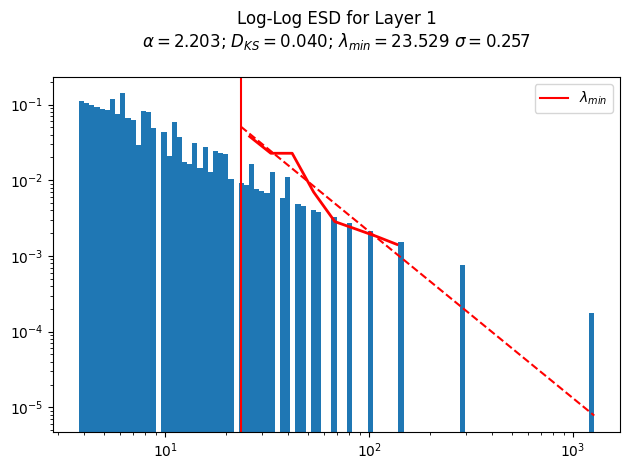

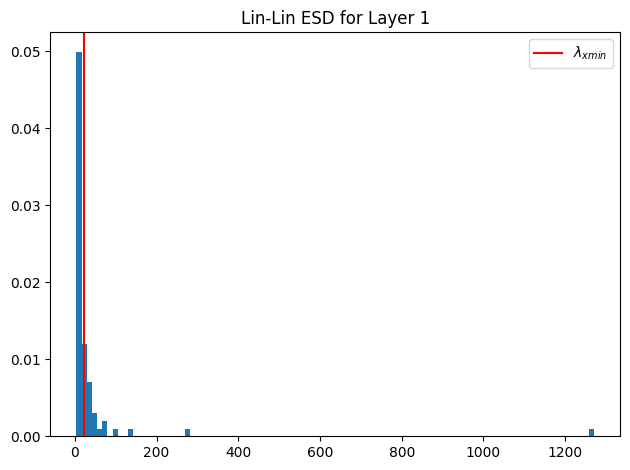

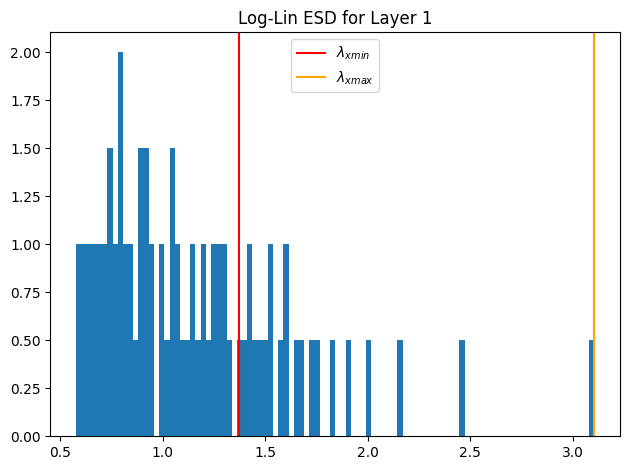

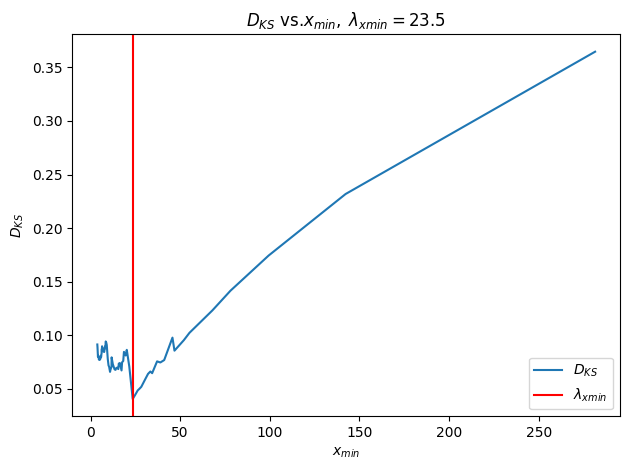

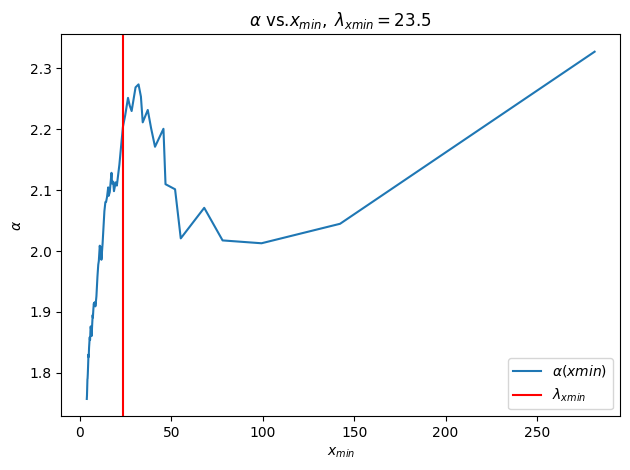

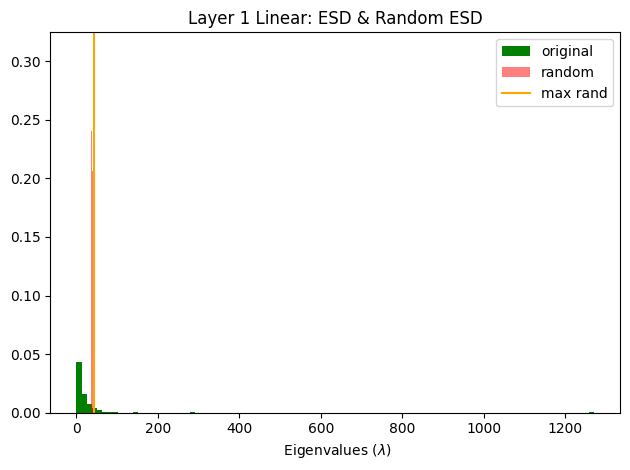

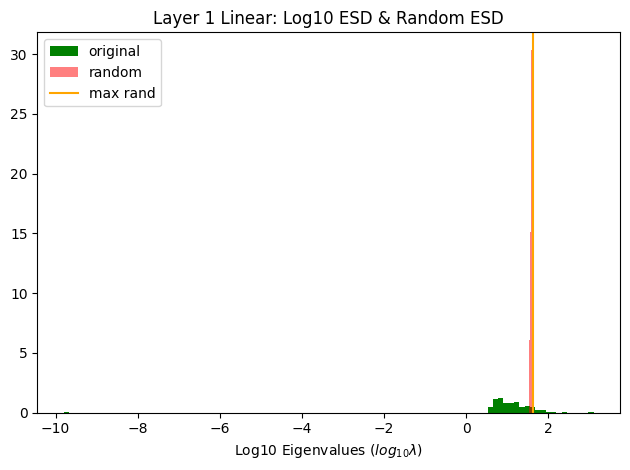

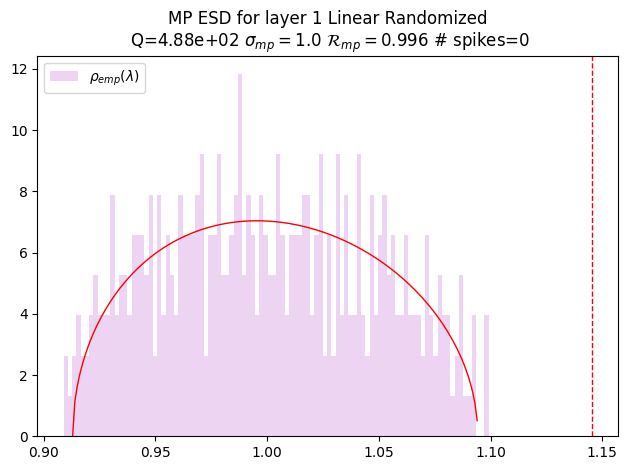

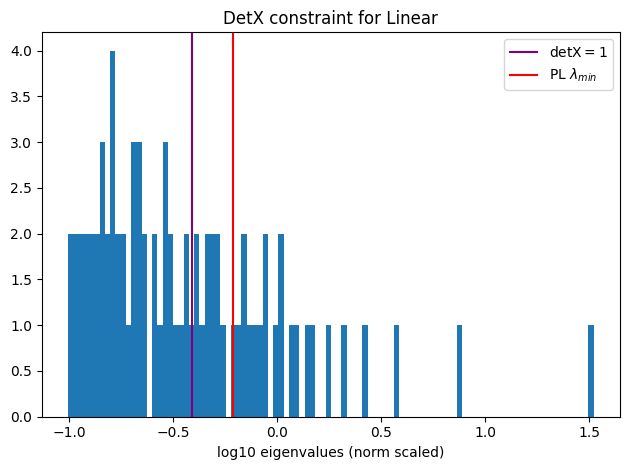

<Figure size 640x480 with 0 Axes>

In [15]:
df = watcher.analyze(plot=True, randomize=True, detX=True)